## Overview

This notebook will show you how to create and query a table or DataFrame that you uploaded to DBFS. [DBFS](https://docs.databricks.com/user-guide/dbfs-databricks-file-system.html) is a Databricks File System that allows you to store data for querying inside of Databricks. This notebook assumes that you have a file already inside of DBFS that you would like to read from.

This notebook is written in **Python** so the default cell type is Python. However, you can use different languages by using the `%LANGUAGE` syntax. Python, Scala, SQL, and R are all supported.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.metrics import confusion_matrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassPredictionError
sns.set_style("darkgrid")
import pyspark

/opt/conda/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Churn Prediction with PySpark").getOrCreate()

In [3]:
df = spark.read.csv('/home/jovyan/churn-bigml-80.csv', header='true', inferSchema='true')

testdf = spark.read.csv('/home/jovyan/churn-bigml-20.csv', header='true', inferSchema='true')

df.printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



In [4]:
df.describe().show()

+-------+-----+------------------+------------------+------------------+---------------+---------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+----------------------+
|summary|State|    Account length|         Area code|International plan|Voice mail plan|Number vmail messages| Total day minutes|   Total day calls|  Total day charge| Total eve minutes|   Total eve calls|  Total eve charge|Total night minutes| Total night calls|Total night charge|Total intl minutes|  Total intl calls| Total intl charge|Customer service calls|
+-------+-----+------------------+------------------+------------------+---------------+---------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-----------

In [5]:
print("The training dataset contains {} samples.".format(df.count()))
print("The test dataset contains {} samples.".format(testdf.count()))

The training dataset contains 2666 samples.
The test dataset contains 667 samples.


In [6]:
df.select("*").toPandas().head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [7]:
df.select("*").toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int32  
 2   Area code               2666 non-null   int32  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int32  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int32  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int32  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int32  
 14  Total night charge      2666 non-null   

In [8]:
# Statistics
df.select("*").toPandas().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Account length,2666.0,100.620405,39.563974,1.00,73.0000,100.00,127.000,243.00
Area code,2666.0,437.438860,42.521018,408.00,408.0000,415.00,510.000,510.00
Number vmail messages,2666.0,8.021755,13.612277,0.00,0.0000,0.00,19.000,50.00
Total day minutes,2666.0,179.481620,54.210350,0.00,143.4000,179.95,215.900,350.80
Total day calls,2666.0,100.310203,19.988162,0.00,87.0000,101.00,114.000,160.00
Total day charge,2666.0,30.512404,9.215733,0.00,24.3800,30.59,36.700,59.64
Total eve minutes,2666.0,200.386159,50.951515,0.00,165.3000,200.90,235.100,363.70
Total eve calls,2666.0,100.023631,20.161445,0.00,87.0000,100.00,114.000,170.00
Total eve charge,2666.0,17.033072,4.330864,0.00,14.0500,17.08,19.980,30.91
Total night minutes,2666.0,201.168942,50.780323,43.70,166.9250,201.15,236.475,395.00


Text(0, 0.5, 'Count')

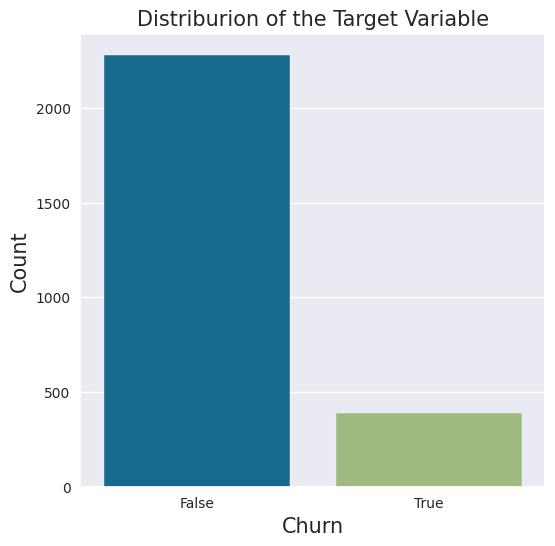

In [9]:
# Visualizing churn 
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,6), dpi=100)
ax = sns.countplot(x="Churn", data=df.select("*").toPandas())
ax.set_title('Distriburion of the Target Variable', fontsize=15)
ax.set_xlabel('Churn', fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)

In [10]:
# Convert binary variable into numeric so plotting is easier. We need to later take mean
df.select("*").toPandas()['Churn'] = df.select("*").toPandas()['Churn'].map({'Yes': 1, 'No': 0})

Text(0.5, 1.0, 'Churn count by International plan')

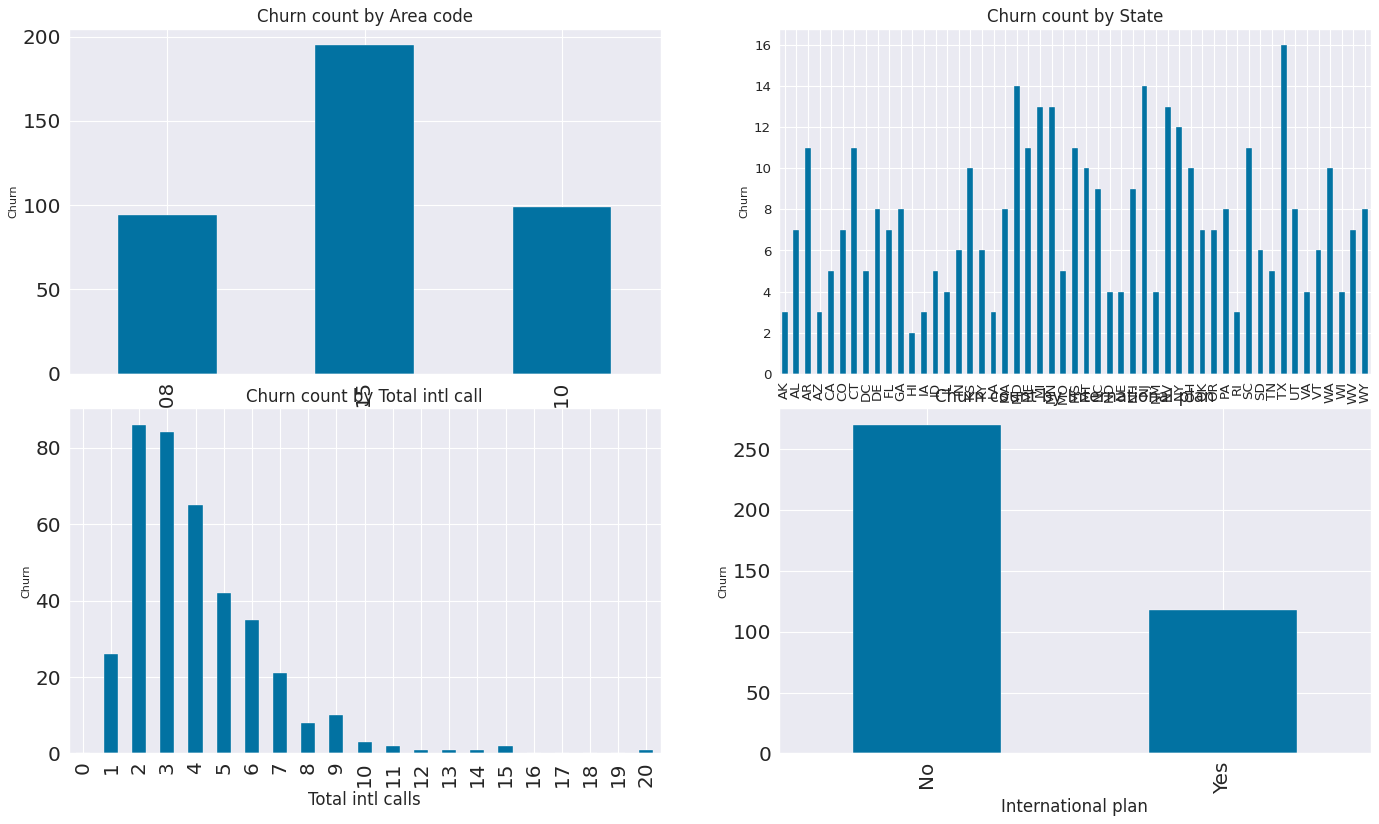

In [11]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(21,12), dpi = 80)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None ,wspace=None, hspace=0.1)
plt.rc('xtick', labelsize = 12)    # fontsize of the tick labels
plt.rc('ytick', labelsize = 12)  

df.select("*").toPandas().groupby('Area code').Churn.sum().plot(kind='bar', ax = ax1)
ax1.set_ylabel('Churn',fontsize = 10)
ax1.set_xlabel('Area code',fontsize = 15)
ax1.tick_params(labelsize = 18)
ax1.set_title('Churn count by Area code',fontsize = 15)

df.select("*").toPandas().groupby('State').Churn.sum().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Churn',fontsize = 10)
ax2.set_xlabel('State Type',fontsize = 15)
ax2.tick_params(labelsize = 12)
ax2.set_title('Churn count by State',fontsize = 15)

df.select("*").toPandas().groupby('Total intl calls').Churn.sum().plot(kind='bar', ax=ax3)
ax3.set_ylabel('Churn',fontsize = 10)
ax3.set_xlabel('Total intl calls',fontsize = 15)
ax3.tick_params(labelsize = 18)
ax3.set_title('Churn count by Total intl call',fontsize = 15)

df.select("*").toPandas().groupby('International plan').Churn.sum().plot(kind='bar', ax=ax4)
ax4.set_ylabel('Churn',fontsize = 10)
ax4.set_xlabel('International plan',fontsize = 15)
ax4.tick_params(labelsize = 18)
ax4.set_title('Churn count by International plan',fontsize = 15)


In [12]:
# Converting to nan since we need to find the mean and that cannot be computed with an empty string. It can be computed using Nan 
import numpy as np
df.select("*").toPandas().replace(" ", np.nan, inplace=True) 
testdf.select("*").toPandas().replace(" ", np.nan, inplace=True) 

In [13]:
df.select("*").toPandas().isna().sum()

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64

Text(9.912123842592592, 0.5, 'Total day charge')

<Figure size 3200x640 with 0 Axes>

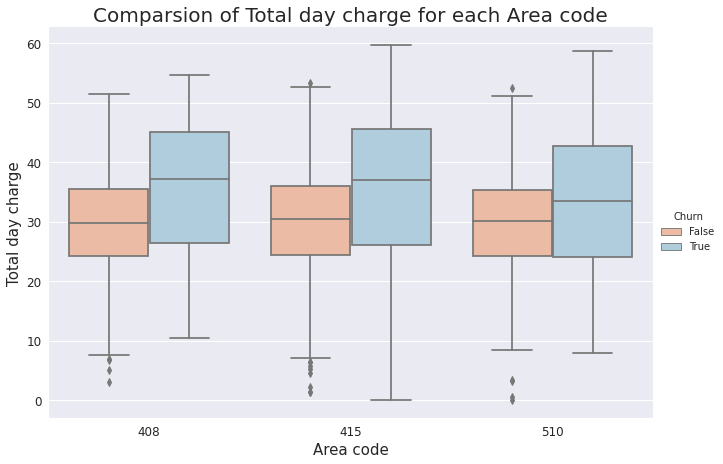

In [14]:
plt.figure(figsize=(40,8), dpi=80)
# Sns.set(rc={'figure.figsize':(25,15)})
ax = sns.catplot(x="Area code", y="Total day charge", hue="Churn", kind="box", data=df.select("*").toPandas(), height = 6,aspect = 1.5,palette = 'RdBu')
plt.title('Comparsion of Total day charge for each Area code',fontsize = 20)
plt.xlabel('Area code',fontsize = 15)
plt.ylabel('Total day charge',fontsize = 15)

In [15]:
# Grouping Tenure data by whether customers churn or not
kde_plot_data_a = df.select("*").toPandas()[df.select("*").toPandas()['Churn'] == 1]['Total day minutes']
kde_plot_data_b = df.select("*").toPandas()[df.select("*").toPandas()['Churn'] == 0]['Total day minutes']

Text(0, 0.5, 'Kernel Density Estimate')

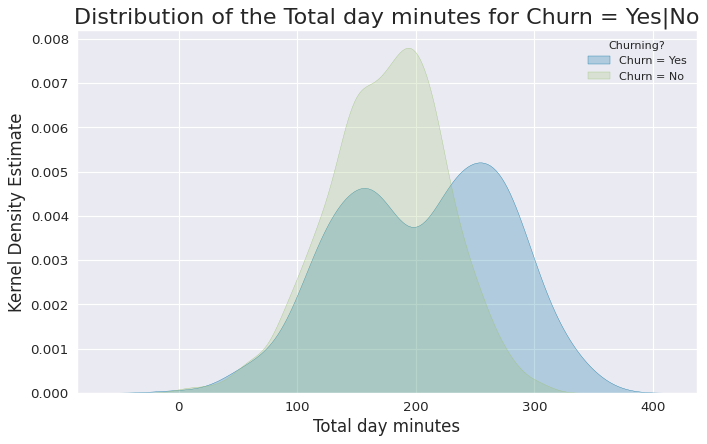

In [16]:
plt.figure(figsize=(10,6), dpi=80)
sns.kdeplot(data = kde_plot_data_a,shade = True, legend = False)
sns.kdeplot(data = kde_plot_data_b, shade = True, legend = False)
plt.legend(title='Churning?', loc='upper right', labels=['Churn = Yes', 'Churn = No'])
plt.title('Distribution of the Total day minutes for Churn = Yes|No',fontsize=20)
plt.xlabel('Total day minutes',fontsize = 15)
plt.ylabel('Kernel Density Estimate',fontsize = 15)

In [17]:
# Grouping Tenure data by whether customers churn or not
kde_plot_data_c = df.select("*").toPandas()[df.select("*").toPandas()['Churn'] == 1]['Total day calls']
kde_plot_data_d = df.select("*").toPandas()[df.select("*").toPandas()['Churn'] == 0]['Total day calls']

Text(0, 0.5, 'Kernel Density Estimate')

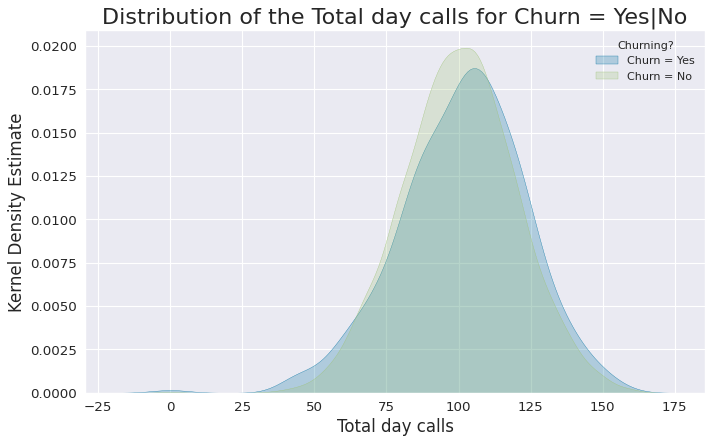

In [18]:
plt.figure(figsize=(10,6), dpi=80)
sns.kdeplot(data = kde_plot_data_c,shade = True, legend = False)
sns.kdeplot(data = kde_plot_data_d, shade = True, legend = False)
plt.legend(title='Churning?', loc='upper right', labels=['Churn = Yes', 'Churn = No'])
plt.title('Distribution of the Total day calls for Churn = Yes|No',fontsize=20)
plt.xlabel('Total day calls',fontsize = 15)
plt.ylabel('Kernel Density Estimate',fontsize = 15)

In [19]:
# Grouping Tenure data by whether customers churn or not
kde_plot_data_e = df.select("*").toPandas()[df.select("*").toPandas()['Churn'] == 1]['Total intl charge']
kde_plot_data_f = df.select("*").toPandas()[df.select("*").toPandas()['Churn'] == 0]['Total intl charge']

Text(0, 0.5, 'Kernel Density Estimate')

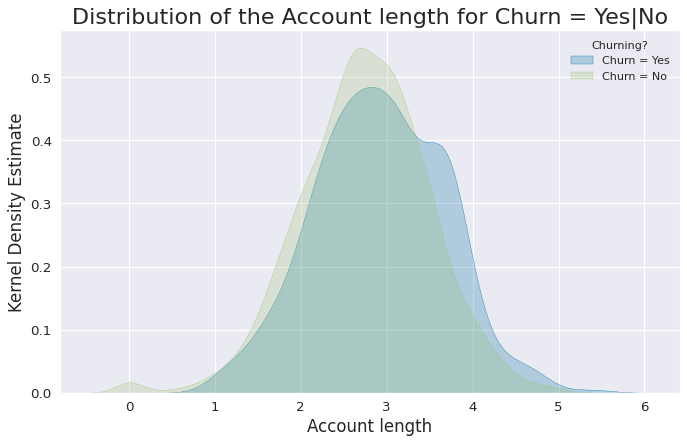

In [20]:
plt.figure(figsize=(10,6), dpi=80)
sns.kdeplot(data = kde_plot_data_e,shade = True, legend = False)
sns.kdeplot(data = kde_plot_data_f, shade = True, legend = False)
plt.legend(title='Churning?', loc='upper right', labels=['Churn = Yes', 'Churn = No'])
plt.title('Distribution of the Account length for Churn = Yes|No',fontsize=20)
plt.xlabel('Account length',fontsize = 15)
plt.ylabel('Kernel Density Estimate',fontsize = 15)

In [21]:
testdf.select("*").toPandas()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,WI,114,415,No,Yes,26,137.1,88,23.31,155.7,125,13.23,247.6,94,11.14,11.5,7,3.11,2,False
663,AL,106,408,No,Yes,29,83.6,131,14.21,203.9,131,17.33,229.5,73,10.33,8.1,3,2.19,1,False
664,VT,60,415,No,No,0,193.9,118,32.96,85.0,110,7.23,210.1,134,9.45,13.2,8,3.56,3,False
665,WV,159,415,No,No,0,169.8,114,28.87,197.7,105,16.80,193.7,82,8.72,11.6,4,3.13,1,False


<AxesSubplot:>

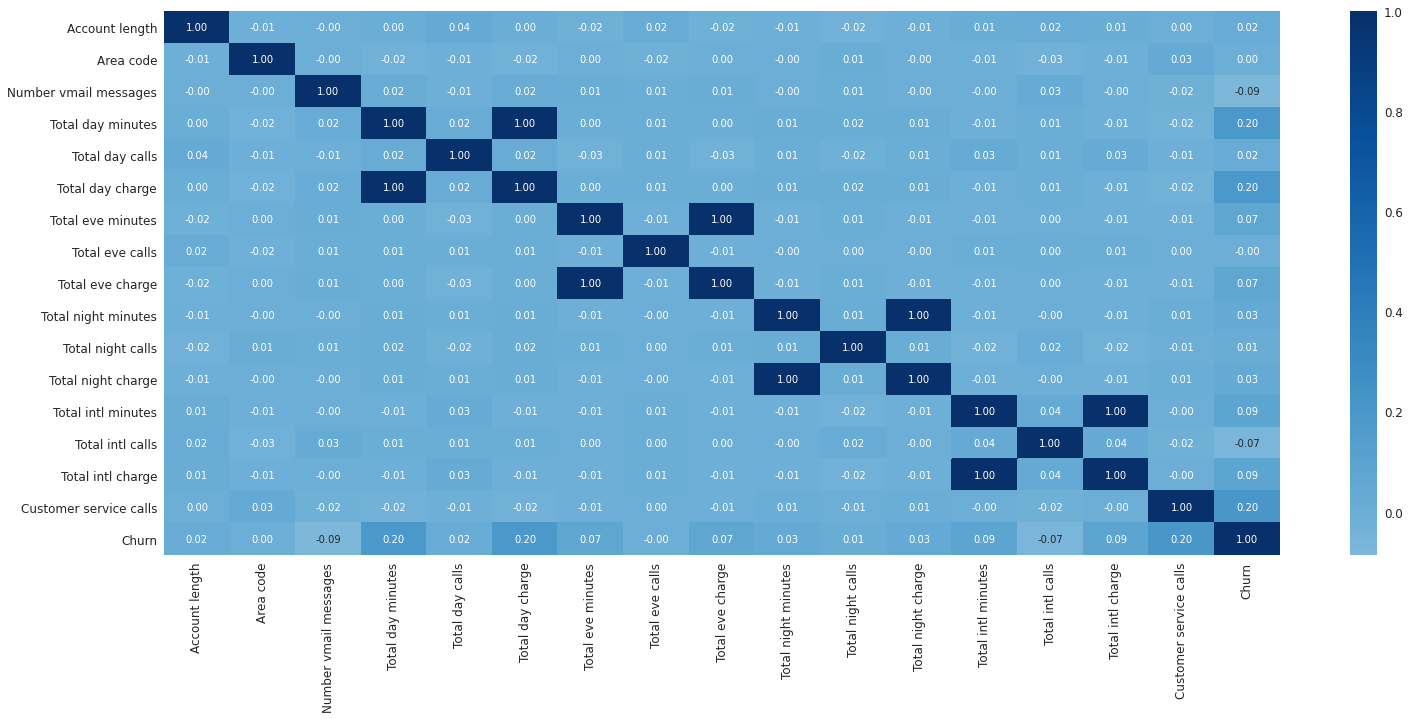

In [22]:
#Plot the heatmap to check the correlation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (25,10))
sns.heatmap(df.select("*").toPandas().corr(), cmap = 'Blues', annot = True, center=0, fmt = '.2f')
#plt.show()

It can be seen that there is good correlation between Total minutes and Total charge. Therefore, it is better to drop one of the can be dropped.


In [24]:
def get_data(df, removeCols):
    df = df.drop(*removeCols) \
        .withColumn("Churn", when(df["Churn"] == 'true', 1.0).otherwise(0.0)) \
        .withColumn('International plan', when(df["International plan"] == 'Yes', 1.0).otherwise(0.0)) \
        .withColumn('Voice mail plan', when(df["Voice mail plan"] == 'Yes', 1.0).otherwise(0.0))
    return df

In [25]:
from pyspark.sql.functions import split, col, round, when

removeCols = ['State', 'Area code', 'Total day minutes', 'Total eve minutes', 'Total night minutes', 'Total intl minutes']

traindf = get_data(df, removeCols=removeCols)

In [26]:
testdf = get_data(testdf, removeCols=removeCols)

In [27]:
testdf.select("*").toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Account length          667 non-null    int32  
 1   International plan      667 non-null    float64
 2   Voice mail plan         667 non-null    float64
 3   Number vmail messages   667 non-null    int32  
 4   Total day calls         667 non-null    int32  
 5   Total day charge        667 non-null    float64
 6   Total eve calls         667 non-null    int32  
 7   Total eve charge        667 non-null    float64
 8   Total night calls       667 non-null    int32  
 9   Total night charge      667 non-null    float64
 10  Total intl calls        667 non-null    int32  
 11  Total intl charge       667 non-null    float64
 12  Customer service calls  667 non-null    int32  
 13  Churn                   667 non-null    float64
dtypes: float64(7), int32(7)
memory usage: 54.8

In [28]:
testdf.select("*").toPandas()

,Account length,International plan,Voice mail plan,Number vmail messages,Total day calls,Total day charge,Total eve calls,Total eve charge,Total night calls,Total night charge,Total intl calls,Total intl charge,Customer service calls,Churn
0,117,0.0,0.0,0,97,31.37,80,29.89,90,9.71,4,2.35,1,0.0
1,65,0.0,0.0,0,137,21.95,83,19.42,111,9.40,6,3.43,4,1.0
2,161,0.0,0.0,0,67,56.59,97,27.01,128,7.23,9,1.46,4,1.0
3,111,0.0,0.0,0,103,18.77,102,11.67,105,8.53,6,2.08,2,0.0
4,49,0.0,0.0,0,117,20.28,109,18.28,90,8.04,1,3.00,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,114,0.0,1.0,26,88,23.31,125,13.23,94,11.14,7,3.11,2,0.0
663,106,0.0,1.0,29,131,14.21,131,17.33,73,10.33,3,2.19,1,0.0
664,60,0.0,0.0,0,118,32.96,110,7.23,134,9.45,8,3.56,3,0.0
665,159,0.0,0.0,0,114,28.87,105,16.80,82,8.72,4,3.13,1,0.0


In [29]:
traindf.select("*").toPandas()

,Account length,International plan,Voice mail plan,Number vmail messages,Total day calls,Total day charge,Total eve calls,Total eve charge,Total night calls,Total night charge,Total intl calls,Total intl charge,Customer service calls,Churn
0,128,0.0,1.0,25,110,45.07,99,16.78,91,11.01,3,2.70,1,0.0
1,107,0.0,1.0,26,123,27.47,103,16.62,103,11.45,3,3.70,1,0.0
2,137,0.0,0.0,0,114,41.38,110,10.30,104,7.32,5,3.29,0,0.0
3,84,1.0,0.0,0,71,50.90,88,5.26,89,8.86,7,1.78,2,0.0
4,75,1.0,0.0,0,113,28.34,122,12.61,121,8.41,3,2.73,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,79,0.0,0.0,0,98,22.90,68,16.12,128,9.96,5,3.19,2,0.0
2662,192,0.0,1.0,36,77,26.55,126,18.32,83,12.56,6,2.67,2,0.0
2663,68,0.0,0.0,0,57,39.29,55,13.04,123,8.61,4,2.59,3,0.0
2664,28,0.0,0.0,0,109,30.74,58,24.55,91,8.64,6,3.81,2,0.0


In [30]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree

def labelData(data):
     #label: row[end], features: row[0:end-1]
    return data.rdd.map(lambda row: LabeledPoint(row[-1], row[:-1]))

training_data, testing_data = labelData(traindf).randomSplit([0.8, 0.2])

print("The two first rows of the training data RDD:")
print(training_data.take(2))
print("============================")

model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                      maxBins=32, impurity='gini')
print(model.toDebugString())

The two first rows of the training data RDD:
[LabeledPoint(0.0, [128.0,0.0,1.0,25.0,110.0,45.07,99.0,16.78,91.0,11.01,3.0,2.7,1.0]), LabeledPoint(0.0, [107.0,0.0,1.0,26.0,123.0,27.47,103.0,16.62,103.0,11.45,3.0,3.7,1.0])]
DecisionTreeModel classifier of depth 2 with 7 nodes
  If (feature 12 <= 3.5)
   If (feature 5 <= 44.730000000000004)
    Predict: 0.0
   Else (feature 5 > 44.730000000000004)
    Predict: 1.0
  Else (feature 12 > 3.5)
   If (feature 5 <= 29.880000000000003)
    Predict: 1.0
   Else (feature 5 > 29.880000000000003)
    Predict: 0.0



In [31]:
def printAllMetrics(predictionsDF):
    TP = predictionsDF.select("label", "predictedLabel").filter("label == 1.0 and predictedLabel == 1.0").count()
    FN = predictionsDF.select("label", "predictedLabel").filter("label == 1.0 and predictedLabel == 0.0").count()
    TN = predictionsDF.select("label", "predictedLabel").filter("label == 0.0 and predictedLabel == 0.0").count()
    FP = predictionsDF.select("label", "predictedLabel").filter("label == 0.0 and predictedLabel == 1.0").count()

    precision_p   = TP/(TP+FP)
    precision_n   = TN/(TN+FN)
    recall_p      = TP/(TP+FN)
    recall_n      = TN/(TN+FP)
    f1_p          = 2*precision_p*recall_p/(precision_p+recall_p)
    f1_n          = 2*precision_n*recall_n/(precision_n+recall_n)
    avg_precision = (precision_p*(TP+FN)+precision_n*(TN+FP))/(TP+FN+TN+FP)
    avg_recall    = (recall_p*(TP+FN)+recall_n*(TN+FP))/(TP+FN+TN+FP)
    avg_f1        = (f1_p*(TP+FN)+f1_n*(TN+FP))/(TP+FN+TN+FP)
    accuracy      = (TN+TP)/(TP+FN+TN+FP)

    print('Precision of True    ', precision_p)
    print('Precision of False   ', precision_n)
    print('** Avg Precision     ', avg_precision)
    print('Recall of True       ', recall_p)
    print('Recall of False      ', recall_n)
    print('** Avg Recall        ', avg_recall)
    print('F1 of True           ', f1_p)
    print('F1 of False          ', f1_n)
    print('** Avg F1            ', avg_f1)
    print('** Accuracy          ', accuracy)

In [32]:
from pyspark.mllib.tree import RandomForest
from time import *

RF_NUM_TREES = 3
RF_MAX_DEPTH = 4
RF_NUM_BINS = 16
RF_MAX_BINS = 227612
start_time = time()

model = RandomForest.trainClassifier(training_data, 
                                     numClasses=2,
                                     categoricalFeaturesInfo={}, \
                                     numTrees=RF_NUM_TREES, featureSubsetStrategy="auto", impurity="gini", \
                                     maxDepth=RF_MAX_DEPTH, maxBins=RF_MAX_BINS, seed=45)

end_time = time()
elapsed_time = end_time - start_time
print("Time to train model: %.3f seconds" % elapsed_time)

predictions = model.predict(testing_data.map(lambda x: x.features))
labels_and_predictions = testing_data.map(lambda x: x.label).zip(predictions)
acc = labels_and_predictions.filter(lambda x: x[0] == x[1]).count() / float(testing_data.count())
print("Model precision: %.3f%%" % (acc * 100))
# model.save(sc, 'dbfs:/FileStore/RandomForestModel/')

Time to train model: 1.516 seconds
Model precision: 86.792%


In [33]:
from pyspark.mllib.evaluation import MulticlassMetrics

def getPredictionsLabels(model, testing_data):
    predictions = model.predict(testing_data.map(lambda r: r.features))
    return predictions.zip(testing_data.map(lambda r: r.label))

def printMetrics(predictions_and_labels):
    metrics = MulticlassMetrics(predictions_and_labels)
    print('Confusion Matrix\n', metrics.confusionMatrix().toArray())
    print('Precision of True    ', metrics.precision(1))
    print('Precision of False   ', metrics.precision(0))
    print('Weighted Precision   ', metrics.weightedPrecision)
    print('Recall of True       ', metrics.recall(1))
    print('Recall of False      ', metrics.recall(0))
    print('Weighted Recall      ', metrics.weightedRecall) 
    print('FMeasure of True     ', metrics.fMeasure(1.0, 1.0))
    print('FMeasure of False    ', metrics.fMeasure(0.0, 1.0))
    print('Weighted fMeasure    ', metrics.weightedFMeasure())
    print('Accuracy             ', metrics.accuracy)

predictions_and_labels = getPredictionsLabels(model, testing_data)

printMetrics(predictions_and_labels)

Confusion Matrix
 [[445.   6.]
 [ 64.  15.]]
Precision of True     0.7142857142857143
Precision of False    0.8742632612966601
Weighted Precision    0.8504175514591795
Recall of True        0.189873417721519
Recall of False       0.9866962305986696
Weighted Recall       0.8679245283018868
FMeasure of True      0.30000000000000004
FMeasure of False     0.9270833333333335
Weighted fMeasure     0.833612421383648
Accuracy              0.8679245283018868


In [34]:
predictionsdf = predictions_and_labels.toDF(["predictedLabel","label"])

predictionsdf.groupBy('label', 'predictedLabel').count().show()
print("========================================")

printAllMetrics(predictionsdf)

+-----+--------------+-----+
|label|predictedLabel|count|
+-----+--------------+-----+
|  1.0|           1.0|   17|
|  0.0|           1.0|    6|
|  1.0|           0.0|   64|
|  0.0|           0.0|  443|
+-----+--------------+-----+

Precision of True     0.68
Precision of False    0.8720472440944882
** Avg Precision      0.8425015142337977
Recall of True        0.2073170731707317
Recall of False       0.9822616407982262
** Avg Recall         0.8630393996247655
F1 of True            0.31775700934579443
F1 of False           0.9238790406673619
** Avg F1             0.8306294973871208
** Accuracy           0.8630393996247655


Stratified Sampling
There are roughly 6 times as many False churn samples as True churn samples. We can put the two sample types on the same footing using stratified sampling. The DataFrames sampleBy() function does this when provided with fractions of each sample type to be returned.

Here we're keeping all instances of the Churn=True class, but downsampling the Churn=False class to a fraction of 388/2278.

In [35]:
stratified_CV_data = traindf.sampleBy('Churn', fractions={0: 388./2278, 1: 1.0}).cache()

stratified_CV_data.groupby('Churn').count().toPandas()

,Churn,count
0,0.0,384
1,1.0,388


In [36]:
training_data, testing_data = labelData(stratified_CV_data).randomSplit([0.8, 0.2])

model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                     impurity='gini', maxBins=32)

predictions_and_labels = getPredictionsLabels(model, testing_data)
printMetrics(predictions_and_labels)

Confusion Matrix
 [[69.  6.]
 [25. 44.]]
Precision of True     0.88
Precision of False    0.7340425531914894
Weighted Precision    0.8039804964539007
Recall of True        0.6376811594202898
Recall of False       0.92
Weighted Recall       0.7847222222222222
FMeasure of True      0.7394957983193275
FMeasure of False     0.8165680473372782
Weighted fMeasure     0.7796375946828435
Accuracy              0.7847222222222222


In [37]:
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml import Pipeline

def get_dummy(df, numericCols, labelCol):
    # Combining a given list of columns into a single vector column features
    assembler = VectorAssembler(inputCols=numericCols, outputCol="features")

    # Index labels, adding metadata to the label column
    indexer = StringIndexer(inputCol=labelCol, outputCol='indexedLabel')

    # Automatically identify categorical features and index them
    featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=2)

    pipeline = Pipeline(stages = [assembler] + [indexer] + [featureIndexer])

    model = pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label', col(labelCol))

    return data.select('features', 'label', 'indexedFeatures', 'indexedLabel')

In [38]:
numericCols = stratified_CV_data.columns
numericCols.remove("Churn")

vectorized_CV_data = get_dummy(traindf, numericCols, "Churn")
vectorized_stratified_CV_data = get_dummy(stratified_CV_data, numericCols, "Churn")
vectorized_final_test_data = get_dummy(testdf, numericCols, "Churn")

In [39]:
vectorized_stratified_CV_data.show(2, False)

+---------------------------------------------------------------+-----+---------------------------------------------------------------+------------+
|features                                                       |label|indexedFeatures                                                |indexedLabel|
+---------------------------------------------------------------+-----+---------------------------------------------------------------+------------+
|[84.0,1.0,0.0,0.0,71.0,50.9,88.0,5.26,89.0,8.86,7.0,1.78,2.0]  |0.0  |[84.0,1.0,0.0,0.0,71.0,50.9,88.0,5.26,89.0,8.86,7.0,1.78,2.0]  |1.0         |
|[168.0,0.0,0.0,0.0,96.0,21.9,71.0,8.92,128.0,6.35,2.0,3.02,1.0]|0.0  |[168.0,0.0,0.0,0.0,96.0,21.9,71.0,8.92,128.0,6.35,2.0,3.02,1.0]|1.0         |
+---------------------------------------------------------------+-----+---------------------------------------------------------------+------------+
only showing top 2 rows



In [40]:
def cvComparing(vectorized_train_data, vectorized_test_data, classifiers, paramGrid, numFolds, roundLevel, seed):
    names = []
    underROC_train = []
    underROC_test = []
    f1_train = []
    f1_test = []
    wp_train = []
    wp_test = []
    wr_train = []
    wr_test = []
    acc_train = []
    acc_test = []

    evaluatorB = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="indexedLabel")

    evaluatorf1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1") 
    evaluatorwp = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision") 
    evaluatorwr = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall") 
    evaluatoracc = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy") 

    for name, clf in classifiers:
        cv = CrossValidator(estimator=clf, estimatorParamMaps=paramGrid, evaluator=evaluatorf1, numFolds=numFolds, seed=seed, collectSubModels=True)
        cvModel = cv.fit(vectorized_train_data)  
        predict_train = cvModel.transform(vectorized_train_data)
        predict_test = cvModel.transform(vectorized_test_data)
        underROC_train.append(evaluatorB.evaluate(predict_train))
        underROC_test.append(evaluatorB.evaluate(predict_test))
        f1_train.append(evaluatoracc.evaluate(predict_train))
        f1_test.append(evaluatoracc.evaluate(predict_test))
        wp_train.append(evaluatorwp.evaluate(predict_train))
        wp_test.append(evaluatorwp.evaluate(predict_test))
        wr_train.append(evaluatorwr.evaluate(predict_train))
        wr_test.append(evaluatorwr.evaluate(predict_test))
        acc_train.append(evaluatoracc.evaluate(predict_train))
        acc_test.append(evaluatoracc.evaluate(predict_test))
        names.append(name)

    cvResults = spark.createDataFrame(zip(names, underROC_train, underROC_test, acc_train, acc_test, f1_train, f1_test, wp_train, wp_test, wr_train, wr_test), 
                                       schema=['Classifier name', 'underROC_train', 'underROC_test', 'Accuracy_train', 'Accuracy_test', 'f1_train', 'f1_test', 'wPrecision_train', 'wPrecision_test', 'wRecall_train', 'wRecall_test'])
  
    for t in cvResults.dtypes:
        if t[1] == 'double':
            cvResults = cvResults.withColumn(t[0], round(cvResults[t[0]], roundLevel))
  
    return cvResults

In [41]:
from pyspark.ml.classification import LogisticRegression, NaiveBayes, LinearSVC, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = ParamGridBuilder().build()

classifiers = []
##############################################
classifiers.append(('LR', LogisticRegression(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('NB', NaiveBayes(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('SVC', LinearSVC(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('DT', DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('RF', RandomForestClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('GBT', GBTClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')))
##############################################


cvResults_CV_data = cvComparing(vectorized_train_data=vectorized_CV_data, vectorized_test_data=vectorized_final_test_data, 
                                classifiers=classifiers, paramGrid=paramGrid, numFolds=5, roundLevel=3, seed=123)

cvResults_stratified_CV_data = cvComparing(vectorized_train_data=vectorized_stratified_CV_data, 
                                           vectorized_test_data=vectorized_final_test_data, classifiers=classifiers, 
                                           paramGrid=paramGrid, numFolds=5, roundLevel=3, seed=123)

In [43]:
cvResults_CV_data.toPandas().set_index('Classifier name')

,underROC_train,underROC_test,Accuracy_train,Accuracy_test,f1_train,f1_test,wPrecision_train,wPrecision_test,wRecall_train,wRecall_test
Classifier name,,,,,,,,,,
LR,0.597,0.577,0.863,0.855,0.863,0.855,0.835,0.820,0.863,0.855
NB,0.621,0.620,0.503,0.499,0.503,0.499,0.820,0.823,0.503,0.499
SVC,0.500,0.500,0.854,0.858,0.854,0.858,0.730,0.735,0.854,0.858
DT,0.841,0.818,0.948,0.945,0.948,0.945,0.948,0.945,0.948,0.945
RF,0.746,0.727,0.925,0.916,0.925,0.916,0.930,0.915,0.925,0.916
GBT,0.921,0.859,0.976,0.954,0.976,0.954,0.976,0.953,0.976,0.954


In [44]:
cvResults_stratified_CV_data.toPandas().set_index('Classifier name')

,underROC_train,underROC_test,Accuracy_train,Accuracy_test,f1_train,f1_test,wPrecision_train,wPrecision_test,wRecall_train,wRecall_test
Classifier name,,,,,,,,,,
LR,0.766,0.236,0.766,0.238,0.766,0.238,0.766,0.566,0.766,0.238
NB,0.582,0.404,0.583,0.565,0.583,0.565,0.604,0.715,0.583,0.565
SVC,0.742,0.232,0.742,0.240,0.742,0.240,0.742,0.566,0.742,0.240
DT,0.911,0.152,0.911,0.124,0.911,0.124,0.914,0.397,0.911,0.124
RF,0.898,0.154,0.898,0.144,0.898,0.144,0.900,0.436,0.898,0.144
GBT,0.929,0.160,0.929,0.124,0.929,0.124,0.934,0.397,0.929,0.124


In [55]:
evaluatorf1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1") 
evaluatorwp = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision") 
evaluatorwr = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall") 
evaluatorac = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy") 


clf = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')
#clf = NaiveBayes(labelCol='indexedLabel', featuresCol='indexedFeatures')

clfModel = clf.fit(vectorized_final_test_data)  
pred_train = clfModel.transform(vectorized_final_test_data)

print('Weighted Precision   ', evaluatorwp.evaluate(pred_train))
print('Weighted Recall      ', evaluatorwr.evaluate(pred_train))
print('F1                   ', evaluatorf1.evaluate(pred_train))
print('Accuracy             ', evaluatorac.evaluate(pred_train))


print("========================================")

printAllMetrics(pred_train.withColumn('predictedLabel', col("prediction")))



Weighted Precision    0.9481354112750475
Weighted Recall       0.9460269865067467
F1                    0.9409242094376606
Accuracy              0.9460269865067467
Precision of True     0.9836065573770492
Precision of False    0.9422442244224423
** Avg Precision      0.9481354112750474
Recall of True        0.631578947368421
Recall of False       0.9982517482517482
** Avg Recall         0.9460269865067467
F1 of True            0.7692307692307693
F1 of False           0.969439728353141
** Avg F1             0.9409242094376606
** Accuracy           0.9460269865067467
